# Residential Real Estate Analysis: King County House Sales

## Luke DiPerna

### October 2022

![houses.jpg](attachment:houses.jpg)
Photo by <a href="https://unsplash.com/@brenoassis?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Breno Assis</a> on <a href="https://unsplash.com/s/photos/houses?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>
  

## Project Goal
***
This project is designed to assist a residential real estate company (KC Real Estate) operating in King County. The company primarily helps homeowners sell their homes. The company needs a reliable and efficient way to properly valuate their clients homes. For this to be feasible, they will need a model that can accurately and reliably predict the price of a home given enough data regarding the features of the home.

Using the data provided by the company, I will build a regression model that can assist them in setting a preliminary selling price.

## Table of Contents
- [Data Preparation](#Data-Preparation)
    - [Data Overview](#Data-Overview)
    - [Data Cleaning/Feature Engineering](#Data-Cleaning/Feature-Engineering)
- [Regression Models](#Regression-Models)
    - [Key Metrics and Assumptions](#Key-Metrics-and-Assumptions)
    - [Custom Functions](#Custom-Functions)
    - [Preliminary Model](#Preliminary-Model)
    - [1st Iteration: Correlated and Non-Colinear Variables](#1st-Iteration:-Correlated-and-Non-Colinear-Variables)
    - [2nd Iteration: All Variables](#2nd-Iteration:-All-Variables)
    - [3rd Iteration: Normalization/Standardization](#3rd-Iteration:-Normalization/Standardization)
    - [4th Iteration: OHE Variables](#4th-Iteration:-OHE-Variables)
    - [5th Iteration: Polynomial Regression (Few Variables)](#5th-Iteration:-Polynomial-Regression-(Few-Variables))
    - [6th Iteration: Polynomial Regression (All Variables)](#6th-Iteration:-Polynomial-Regression-(All-Variables))
    - [Model Validation](#Model-Validation)
- [Regression Results](#Regression-Results)
    - [Recommendations](#Recommendations)
    - [Next Steps](#Next-Steps)

## Data Preparation
***
The data for this project is the King County house sales dataset. It contains 21,596 house sales in the county in 2014 and 2015. This project assumes that the data is current, and as a result does not take inflation or other market factors into account.

The dataset is relatively clean, with few null values and errors, but still requires some attention before linear regression can be performed.

In [1]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from yellowbrick.regressor import ResidualsPlot
%matplotlib inline

### Data Overview

In [2]:
house_df = pd.read_csv('data/kc_house_data.csv')
house_df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,360000.0,3,2.50,1530,1131,3.0,NO,NONE,...,8 Good,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,6600060120,2/23/2015,400000.0,4,2.50,2310,5813,2.0,NO,NONE,...,8 Good,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,NO,NONE,...,7 Average,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,291310100,1/16/2015,400000.0,3,2.50,1600,2388,2.0,NaN,NONE,...,8 Good,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


In [3]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

There are four features with some null values (`waterfront`, `view`, `yr_built`, and `yr_renovated`). Additionally, some of the features, like condition and grade, will likely be more useful as either `int64` or `category` dtypes, so I will need to examine some of the `object` features

### Data Cleaning/Feature Engineering

I do not need the exact date of each sale, but I do want to know the age of each house at the time of sale, so I will create a `house_age` feature. In addition, since so few houses have been renovated, I will bin the renovation data by creating a boolean feature `renovated` to indicate if the house has been renovated or not.

In [4]:
# create yr_sold and use it to calculate house_age
house_df['yr_sold'] = house_df['date'].str[-4:].astype('int64')
house_df['house_age'] = house_df['yr_sold'] - house_df['yr_built']

# some houses appear to have been sold before they were finished building,
# so this sets house age to 0 instead of -1
house_df['house_age'][house_df['house_age'] == -1] = 0

# create renovated feature
conditional = ((house_df['yr_renovated']==0) |
               (house_df['yr_renovated'].isna())
              )
house_df['renovated'] = np.where(conditional, 0, 1)
# house_df['renovated'].astype('category')

house_df['grade'] = house_df['grade'].str.strip(string.ascii_letters+string.whitespace).astype('int64')

<ipython-input-4-c229ce65314f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  house_df['house_age'][house_df['house_age'] == -1] = 0


In [5]:
house_df['view'].value_counts()

NONE         19422
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
Name: view, dtype: int64

In [6]:
house_df['waterfront'].value_counts()

NO     19075
YES      146
Name: waterfront, dtype: int64

Since NONE is the most common value for `view`, and NO is the most common value for `waterfront`, I will use those values to fill the null fields.

In [7]:
house_df['view'].fillna('NONE', inplace=True)
house_df['waterfront'].fillna('NO', inplace=True)

The `waterfront`, `condition`, and `view` columns are all categorical, but for now I want to treat them as numeric values since they are ordinal.

In [8]:
# change the columns to numeric
house_df['waterfront'].replace({'NO': 0, 'YES': 1}, inplace=True)

cnd_rpl = {'Poor': 1, 'Fair': 2, 'Average': 3, 'Good': 4, 'Very Good': 5}
house_df['condition'].replace(cnd_rpl, inplace=True)

view_rpl = {'NONE': 1, 'FAIR': 2, 'AVERAGE': 3, 'GOOD': 4, 'EXCELLENT': 5}
house_df['view'].replace(view_rpl, inplace=True)

In [9]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     21597 non-null  int64  
 9   view           21597 non-null  int64  
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

Now the data is almost ready. I will drop some unnecessary columns, then build the preliminary model. `sqft_basement` has some errors and would require more cleaning before it could be used, but the feature does not correlate well with price and is highly colinear with other features such as `sqft_above`, so it will be dropped. In addition, I no longer need the `yr_sold` or `yr_built` column now that I have `house_age`, so they will be dropped as well. I will also drop `yr_renovated`, which has been replaced with the `renovated` column. Lastly, the `date` and `id` columns will also be dropped. 

In [10]:
house_df.drop(['yr_sold', 'date', 'id', 'sqft_basement', 'yr_renovated', 'yr_built'], axis=1, inplace=True)

## Regression Models
***
I will begin by building a simple linear regression model using the feature that most highly correlates with `price`. This will be my baseline. From there, I will build more complex models using additional features/methods to refine the model and increase accuracy. It is important to keep in mind that the goal of the stakeholders is model accuracy, as we will see later.

### Key Metrics and Assumptions
In order to compare the models, I will be using the following metrics:

- **Root Mean Squared Error (RMSE)**: measures the standard deviation of the models prediction errors (residuals).
- **R-squared**: measures goodness-of-fit for the model. The score (ranging between 0-1) will naturally increase as the number of variables in the model increase, so we will also need the adjusted score.
- **Adjusted R-squared**: accounts for the number of features included in the model. This score will drop relative to the unadjusted score if the additional features do not improve the model.
- **Cross-Validation Score**: the mean of the model's R-squared scores when performed 10 times on different splits of the training data.

I will then validate each model by testing if they meet the assumptions of linear regression. These assumptions are:

- **Linearity**: the relationship between the independent and dependent variables is linear. As we will see, this assumption no longer applies once we introduce polynomial regression, since our model will no longer be linear.
- **Normality**: the dependent variable is normally distributed for any fixed value of the independent variables.
- **No multi-collinearity**: the independent variables are not highly correlated with one another (collinear).
- **Homoscedasticity**: the variance of the residuals is constant for all values of X.

### Custom Functions

Before I can build the models, I need to write a few functions and prepare a dataframe to assist in the process. I will create:

- a dataframe to store and compare the metrics from each model
- a function to calculate the adjusted R-squared of each model
- a function to create a regression model, calculate the necessary metrics, and store them in the dataframe

In [11]:
# dataframe to store the results from each model
model_results = pd.DataFrame({'Model': [],
                              'Details':[],
                              'RMSE':[],
                              'R2 (train)':[],
                              'Adjusted R2 (train)':[],
                              'Cross Validation':[],
                              'R2 (test)':[],
                              'Adjusted R2 (test)':[]})

In [12]:
def adjustedR2(r2,n,k):
    '''
    Will use the R-squared score, n number of observations, and k number of variables in the model
    to create an adjusted R-squared score.
    -
    Inputs:  
    r2 = the R-squared score for the model
    n = the number of observations (entries) in the data
    k = the number of variables (features) used in the model.
    -
    Output:
    Adjusted R-squared
    '''
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))

In [13]:
def eval_model(X, y, X_train, X_test, y_train, y_test, model_df, model_name, details):
    
    '''
    Will take the data and create a linear regression model using the sklearn LinearRegression() class.
    Will store the results and metrics into a dataframe.
    
    -
    Inputs:
    
    X = the dataframe with the independent variables (seperated by column) for all observations.
    y = the dataframe with only the dependent variable for all observations.
    X_train = the X data used as the training set. Will be used to fit the model.
    X_test = the X data used as the test set. Will be used to test the model.
    y_train = the y data for the training set.
    y_test = the y data for the test set.
    model_df = dataframe to store model metrics
    model_name = string containing the name to identify the model
    details = info about the specific model
    
    -
    Output:
    model_df = results dataframe with the new model metrics included
    test_pred = model predictions on the test set
    
    '''
    
    lr = LinearRegression()
    model = lr.fit(X_train, y_train)
    train_pred = lr.predict(X_train)
    test_pred = lr.predict(X_test)
    
    rmse = mean_squared_error(y_true=y_test, y_pred=test_pred, squared=False)
    
    trainR2 = model.score(X_train, y_train)
    adjusted_trainR2 = adjustedR2(trainR2, len(y), X.shape[1])
    
    cv = cross_val_score(model, X_train, y_train, cv=10).mean()
    
    testR2 = model.score(X_test, y_test)
    adjusted_testR2 = adjustedR2(testR2, len(y), X.shape[1])
    
    r = model_results.shape[0]
    model_df.loc[r] = [model_name, details, rmse, trainR2, adjusted_trainR2, cv, testR2, adjusted_testR2]
    
    return model_df, test_pred

### Preliminary Model

For a baseline, I will create a regression model using only 1 variable. It will be the variable with the highest correlation to our dependent variable, `price`.

In [14]:
# sort variables by correlation to price
house_df.corr()['price'].map(abs).sort_values(ascending=False)

price            1.000000
sqft_living      0.701917
grade            0.667951
sqft_above       0.605368
sqft_living15    0.585241
bathrooms        0.525906
view             0.393497
bedrooms         0.308787
lat              0.306692
waterfront       0.264306
floors           0.256804
renovated        0.117543
sqft_lot         0.089876
sqft_lot15       0.082845
house_age        0.053896
zipcode          0.053402
condition        0.036056
long             0.022036
Name: price, dtype: float64

`sqft_living` is the highest correlated feature, so I will use it to create the first model. To do this, I will declare the `X` (independent variables) and `y` (dependent variable) and split them into a training and test set. I can then create and evaluate the model using the function `eval_model` I created above.

In [15]:
X = house_df[['sqft_living']]
y = house_df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.75, random_state=99)

In [16]:
eval_model(X, y, X_train, X_test, y_train, y_test, model_results, 'Preliminary Model', '1 feature')[0]

,Model,Details,RMSE,R2 (train),Adjusted R2 (train),Cross Validation,R2 (test),Adjusted R2 (test)
0,Preliminary Model,1 feature,269556.49184,0.489914,0.48989,0.487984,0.500022,0.499999


The model has an R-squared score of around 49% for both the training and test sets. This is nowhere near useful enough, as seen by the RMSE, which indicates that the standard deviation of the model's predictions are, on average, about $269,556. Still, it is a useful starting point.

Another thing to note is that since there was only 1 variable, there is no significant difference between the R-squared and adjusted R-squared scores.

The other thing I need to do is validate the models. I will do a brief initial vailidation, and once I have a final model I will examine it in more detail. Initially, I will examine the residuals to check for homoscedasticity. Ideally, the residuals should be evenly distributed as opposed to cone-shaped, and the QQ plot should be a straight, diagonal line.

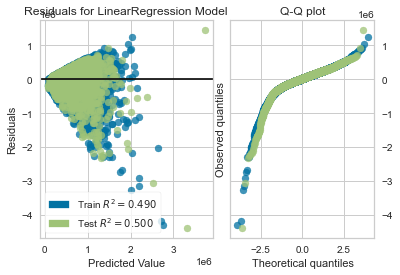

In [17]:
lr = LinearRegression()
visualizer = ResidualsPlot(lr, hist=False, qqplot=True)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show();

The residual plot demonstrates that the model fails the homoscedasticity assumption. The cone-shaped residuals indicate heteroscedasticity. There are several possible reasons for this, including: outliers, missing key independent variables, and non-normallly distributed variables. This model likely contains all three, so it is unsurprising that there is heteroscedasticity.

### 1st Iteration: Correlated and Non-Collinear Variables

This next model will increase the number of independent variables by selecting those with a high correlation to the target `price`. But to avoid issues with collinearity, I will remove independent variables that are highly correlated with each other, keeping the variable with the highest correlation to `price`. To do this I will:

- find the correlation between all variables
- select all variables with a correlation to `price` above 0.25
- remove collinear variables (correlation above 0.5)

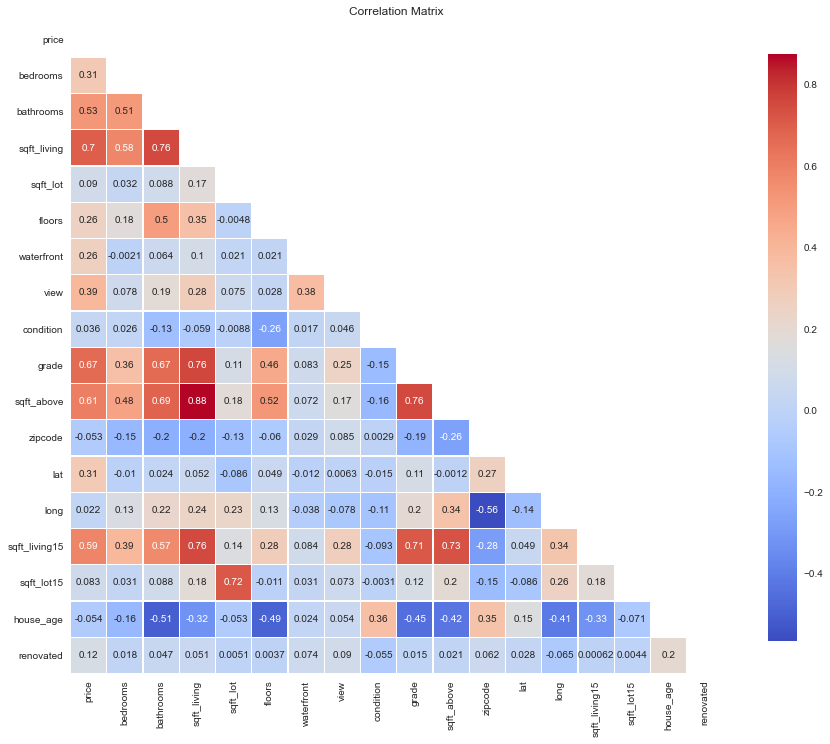

In [18]:
# hide upper half of heatmap with mask
mask = np.zeros_like(house_df.corr(), dtype=bool) 
mask[np.triu_indices_from(mask)] = True 

fig, ax = plt.subplots(figsize=(16, 12))
plt.title('Correlation Matrix')

sns.heatmap(house_df.corr(), linewidths=0.25, square=True, cmap='coolwarm', 
            linecolor='w', annot=True, annot_kws={"size":10}, mask=mask, cbar_kws={"shrink": .9});

It appears that the variables containing square footage are all highly collinear with at least one other square footage variable, so many of them will need to be dropped. Additionally, the features with a correlation to `price` of near 0 will be removed as well.

In [19]:
# remove non-correlated and collinear variables
X = house_df.drop(['price', 'sqft_living15', 'sqft_lot15', 'sqft_above',
                   'zipcode', 'condition', 'sqft_lot', 'long', 'house_age', 'renovated'], axis=1)
y = house_df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.75, random_state=99)

In [20]:
eval_model(X, y, X_train, X_test, y_train, y_test, model_results, '1st Iteration', 'remove collinear and non-corr vars')[0]

,Model,Details,RMSE,R2 (train),Adjusted R2 (train),Cross Validation,R2 (test),Adjusted R2 (test)
0,Preliminary Model,1 feature,269556.491840,0.489914,0.489890,0.487984,0.500022,0.499999
1,1st Iteration,remove collinear and non-corr vars,223474.921916,0.657451,0.657324,0.655113,0.656356,0.656229


This model is a significant improvement over the first. The R-squared score has improved from around 49% to 65%, and the RMSE has dropped as well. This indicates that the extra variables I have included are helping the model.

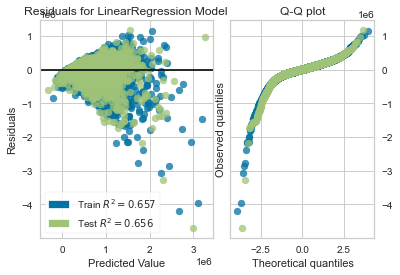

In [21]:
lr = LinearRegression()
visualizer = ResidualsPlot(lr, hist=False, qqplot=True)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show();

The model is still heteroscedastic, however. I know there are outliers, and the model may still be missing key variables, or there are issues with the normality of the variables.

### 2nd Iteration: All Variables

Given that the extra variables improved the model, it is possible that including all variables may improve it even further. The risk is that it may increase the heteroscedasticity of the model, but given that the previous models are already heteroscedastic, it is worth seeing how the less correlated variables contribute to the model.

In theory, the extra variables could make the model more accurate at the cost of interpretability, since collinear features will make it much more difficult to determine the impact that each independent feature is exerting on the model. Additionally, the extra features could make the adjusted R-squared scores much lower than the unadjusted scores, if the extra features are not significantly contributing to the model.

In [22]:
# include all variables
X = house_df.drop(['price'], axis=1)
y = house_df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.75, random_state=99)

In [23]:
eval_model(X, y, X_train, X_test, y_train, y_test, model_results, '2nd Iteration', 'all features')[0]

,Model,Details,RMSE,R2 (train),Adjusted R2 (train),Cross Validation,R2 (test),Adjusted R2 (test)
0,Preliminary Model,1 feature,269556.491840,0.489914,0.489890,0.487984,0.500022,0.499999
1,1st Iteration,remove collinear and non-corr vars,223474.921916,0.657451,0.657324,0.655113,0.656356,0.656229
2,2nd Iteration,all features,208606.305222,0.699789,0.699552,0.697401,0.700563,0.700327


The inclusion of all variables has improved the model even more, from an R-squared of 65% to 70%. Surprisingly, the adjusted R-squared scores are very close to the unadjusted scores, which indicates that the extra features helped improve the model, even though many features had a low correlation with `price`. The similarity of the train and test scores also indicates that the model is not suffering from overfitting.

Overall, this is already a large improvement over the baseline model. Since the primary goal for the stakeholder is an accurate model, it makes since to use all available features since the adjusted R-squared score does not suffer and collinearity is less of a concern.

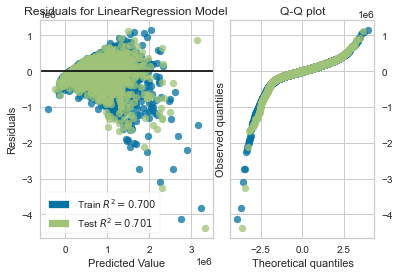

In [24]:
lr = LinearRegression()
visualizer = ResidualsPlot(lr, hist=False, qqplot=True)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show();

The model still demonstrates heteroscedasticity, though that is unsurprising. Since several collinear variables were included, it should be expected that the model would remain heteroscedastic.

### 3rd Iteration: Normalization/Standardization

While not always necessary for linear regression models, it can sometimes help to normalize and/or standardize the data before fitting a model. Since much of the data is heavily skewed, I will try to normalize the continuous variables to see if model performance improves.

To do this I will be using the sklearn `PowerTransformer` class, which will both normalize and standardize the continuous variables.

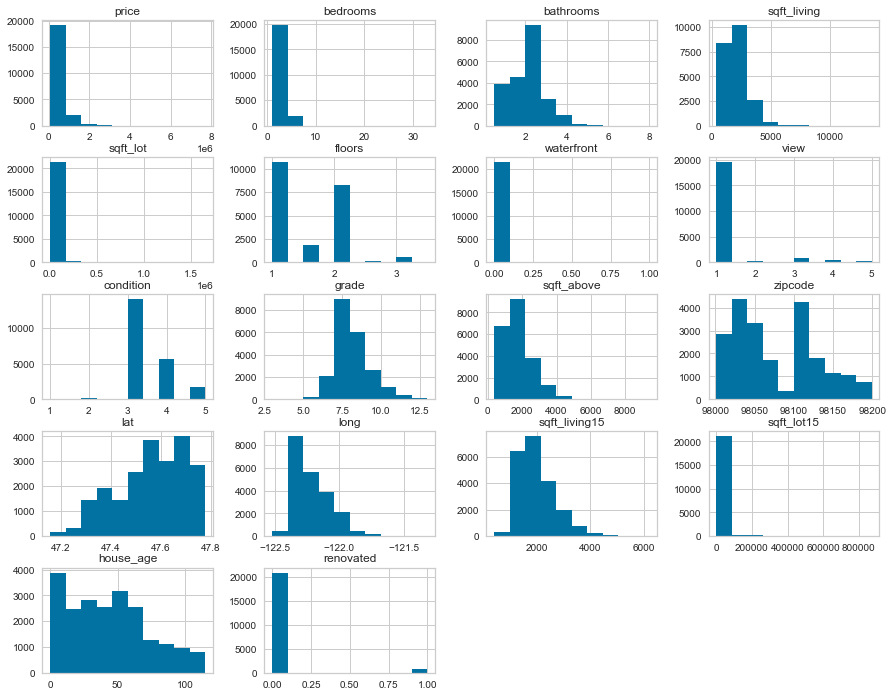

In [25]:
house_df.hist(figsize=(15,12));

Looking at the feature histograms shows that several of them are heavily skewed and non-normal. I will leave the categorical variables and focus on the continuous variables: `sqft_lot`, `sqft_living`, `sqft_above`, `sqft_living15`, and `sqft_lot15`.

In [26]:
X = house_df.drop(['price'], axis=1)
y = house_df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.75, random_state=99)

In [27]:
# select features for transformation
trans_features = ['sqft_lot', 'sqft_living', 'sqft_above', 'sqft_living15', 'sqft_lot15']
trans_train = X_train[trans_features]
trans_test = X_test[trans_features]

pt = PowerTransformer()

# transform train data and replace untransformed data
trans_X_train = pt.fit_transform(trans_train)
tx_train = pd.DataFrame(trans_X_train, index=trans_train.index, columns=trans_features)
X_train.drop(trans_features, axis=1, inplace=True)
X_train = pd.concat([X_train, tx_train], axis=1)

# transform test data and replace untransformed data
trans_X_test = pt.transform(trans_test)
tx_test = pd.DataFrame(trans_X_test, index=trans_test.index, columns=trans_features)
X_test.drop(trans_features, axis=1, inplace=True)
X_test = pd.concat([X_test, tx_test], axis=1)

C:\Users\diper\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\diper\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [28]:
eval_model(X, y, X_train, X_test, y_train, y_test, model_results, '3rd Iteration', 'normalization/standardization')[0]

,Model,Details,RMSE,R2 (train),Adjusted R2 (train),Cross Validation,R2 (test),Adjusted R2 (test)
0,Preliminary Model,1 feature,269556.491840,0.489914,0.489890,0.487984,0.500022,0.499999
1,1st Iteration,remove collinear and non-corr vars,223474.921916,0.657451,0.657324,0.655113,0.656356,0.656229
2,2nd Iteration,all features,208606.305222,0.699789,0.699552,0.697401,0.700563,0.700327
3,3rd Iteration,normalization/standardization,223741.772341,0.662832,0.662566,0.661560,0.655535,0.655263


The transformed features are far more normalized than before, but this has failed to improve the model. In fact, it is performing slightly worse. This is often the case with linear regression models, where the true values can be useful in determining the relative weight of each variable and its relationship to the dependent variable.

I also performed the same transformation on all variables, as well as used the sklearn `RobustScaler` class to scale the variables instead, but neither model produced useful results.

### 4th Iteration: OHE Variables

The next step is to examine the categorical features. They have been treated as numeric so far because they are ordinal, meaning they have an inherent order, but it is possible that treating them as binary may yield better results. This will require one-hot-encoding the categorical features before creating the model.

Since the numeric values for many of the categorical features are small (for example, the values for `bathrooms` and `condition` are all between 0-10), and the other numeric variables like `sqft_living` are large (between 0-10,000), it is possible that the categorical variables are being under-represented in the previous models. One-hot-encoding will possibly correct that, leading to a more accurate model.

In [29]:
X = house_df.drop(['price'], axis=1)
y = house_df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.75, random_state=99)

In [30]:
# create train/test dataframes with only categorical variables
cats = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade']
cats_train = X_train[cats]
cats_test = X_test[cats]

ohe = OneHotEncoder(handle_unknown='ignore')

# create OHE train dataframe
trans_train = ohe.fit_transform(cats_train).toarray()
# get_feature_names is deprecated. current: get_feature_names_out
column_names = ohe.get_feature_names(cats_train.columns)
ohe_train = pd.DataFrame(trans_train, index=cats_train.index, columns=column_names)
ohe_train

,bedrooms_1,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6,bedrooms_7,bedrooms_8,bedrooms_9,bedrooms_10,...,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13
21270,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9198,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
18939,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3188,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7399,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21572,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1768,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9929,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3240,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Now that I have the OHE dataframe, I can use it to replace the categorical features in the original train dataframe.

In [31]:
X_train.drop(cats, axis=1, inplace=True)
X_train = pd.concat([X_train, ohe_train], axis=1)
X_train

C:\Users\diper\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,sqft_living,sqft_lot,sqft_above,zipcode,lat,long,sqft_living15,sqft_lot15,house_age,renovated,...,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13
21270,1914,3272,1914,98055,47.4297,-122.189,1714,3250,5,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9198,1160,17700,1160,98133,47.7244,-122.331,1440,9000,68,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
18939,1320,8625,1320,98056,47.4902,-122.179,1370,8295,57,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3188,1740,4200,1640,98117,47.6782,-122.361,1660,3750,94,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7399,2540,5612,2540,98059,47.4965,-122.157,2380,6303,15,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21572,1210,1278,1020,98117,47.6756,-122.375,1210,1118,7,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1768,4370,22863,3670,98033,47.6878,-122.215,2980,22863,107,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9929,3710,34200,2510,98074,47.6101,-122.047,1720,23100,28,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3240,1870,9825,1250,98045,47.4639,-121.744,1380,11475,20,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


I will repeat the process for the test set.

In [32]:
trans_test = ohe.transform(cats_test).toarray()
# get_feature_names is deprecated. current: get_feature_names_out
column_names = ohe.get_feature_names(cats_test.columns)
ohe_test = pd.DataFrame(trans_test, index=cats_test.index, columns=column_names)

X_test.drop(cats, axis=1, inplace=True)
X_test = pd.concat([X_test, ohe_test], axis=1)

C:\Users\diper\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [33]:
eval_model(X, y, X_train, X_test, y_train, y_test, model_results, '3rd Iteration', 'OHE variables')[0]

,Model,Details,RMSE,R2 (train),Adjusted R2 (train),Cross Validation,R2 (test),Adjusted R2 (test)
0,Preliminary Model,1 feature,269556.491840,0.489914,0.489890,0.487984,0.500022,0.499999
1,1st Iteration,remove collinear and non-corr vars,223474.921916,0.657451,0.657324,0.655113,0.656356,0.656229
2,2nd Iteration,all features,208606.305222,0.699789,0.699552,0.697401,0.700563,0.700327
3,3rd Iteration,normalization/standardization,223741.772341,0.662832,0.662566,0.661560,0.655535,0.655263
4,3rd Iteration,OHE variables,199108.458588,0.742964,0.742761,0.723259,0.727209,0.726994


One-hot-encoding appears to have slightly improved upon the previous best model, with the R-squared score increasing from 70% to around 72%. The train R-squared is actually 74%, but the cross-validation score indicates that is likely only because of the particular split used to create the train set, so the model does not appear to be suffering from over-fitting. Additionally, the extra variables that were created when performing one-hot-encoding do not appear to have diluted the results, as seen by the similarity of the adjusted and unadjusted R-squared scores. Heteroscedasticity, however, continues to be an issue, as seen below.

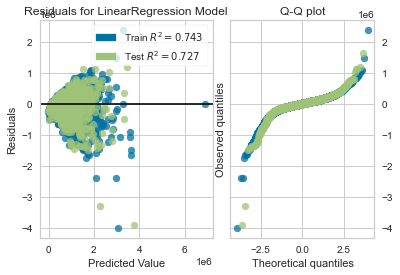

In [34]:
lr = LinearRegression()
visualizer = ResidualsPlot(lr, hist=False, qqplot=True)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show();

### 5th Iteration: Polynomial Regression (Few Variables)

Most of the assumptions of linear regression have been broken by the previous models. I have attempted to account for non-normality, heteroscedasticity, and collinearity with varying results. But now I want to examine the linear assumption. It is possible that the relationship between the independent and dependent variables is non-linear. If this is the case, it could be negatively affecting the models and contributing to the other failed assumptions. I will test this by performing Polynomial Regression (multiple regression).

This will allow me to account for possible interactions between the variables. If I am able to identify some useful interactions, they can help improve the model by providing additional useful features, at the cost of explainability.

Since I am not well-versed in real estate, I do not have the domain knowledge necessary to know what features are likely to have strong interactions ahead of time. Instead, I will examine all potential variable interactions and work backward from there. I will do this using polynomial regression, which will create a new variable for each feature pair by multiplying the 2 features together.

First, I will perform polynomial regression with the correlated and non-collinear variables I used in the 1st Iteration model. Then I will attempt it again with all variables.

In [35]:
# remove non-correlated and collinear variables
X = house_df.drop(['price', 'sqft_living15', 'sqft_lot15', 'sqft_above',
                   'zipcode', 'condition', 'sqft_lot', 'long', 'house_age', 'renovated'], axis=1)
y = house_df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.75, random_state=99)

In [36]:
pf = PolynomialFeatures(degree=2) # degree is the exponent. In this case the variables are squared.
pf.fit(X_train)
# get_feature_names is deprecated. current: get_feature_names_out
poly_train = pd.DataFrame(pf.transform(X_train), columns=pf.get_feature_names(X_train.columns))
poly_test = pd.DataFrame(pf.transform(X_test), columns=pf.get_feature_names(X_test.columns))
poly_train

,1,bedrooms,bathrooms,sqft_living,floors,waterfront,view,grade,lat,bedrooms^2,...,waterfront^2,waterfront view,waterfront grade,waterfront lat,view^2,view grade,view lat,grade^2,grade lat,lat^2
0,1.0,4.0,2.50,1914.0,2.0,0.0,1.0,8.0,47.4297,16.0,...,0.0,0.0,0.0,0.0,1.0,8.0,47.4297,64.0,379.4376,2249.576442
1,1.0,2.0,1.00,1160.0,1.0,0.0,1.0,7.0,47.7244,4.0,...,0.0,0.0,0.0,0.0,1.0,7.0,47.7244,49.0,334.0708,2277.618355
2,1.0,3.0,1.00,1320.0,1.0,0.0,1.0,7.0,47.4902,9.0,...,0.0,0.0,0.0,0.0,1.0,7.0,47.4902,49.0,332.4314,2255.319096
3,1.0,3.0,1.50,1740.0,1.5,0.0,1.0,7.0,47.6782,9.0,...,0.0,0.0,0.0,0.0,1.0,7.0,47.6782,49.0,333.7474,2273.210755
4,1.0,3.0,2.50,2540.0,2.0,0.0,1.0,9.0,47.4965,9.0,...,0.0,0.0,0.0,0.0,1.0,9.0,47.4965,81.0,427.4685,2255.917512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16192,1.0,2.0,1.50,1210.0,2.0,0.0,1.0,8.0,47.6756,4.0,...,0.0,0.0,0.0,0.0,1.0,8.0,47.6756,64.0,381.4048,2272.962835
16193,1.0,4.0,2.25,4370.0,2.5,0.0,4.0,10.0,47.6878,16.0,...,0.0,0.0,0.0,0.0,16.0,40.0,190.7512,100.0,476.8780,2274.126269
16194,1.0,5.0,3.25,3710.0,2.0,0.0,1.0,8.0,47.6101,25.0,...,0.0,0.0,0.0,0.0,1.0,8.0,47.6101,64.0,380.8808,2266.721622
16195,1.0,3.0,2.50,1870.0,1.0,0.0,1.0,7.0,47.4639,9.0,...,0.0,0.0,0.0,0.0,1.0,7.0,47.4639,49.0,332.2473,2252.821803


As seen above, polynomial regression has increased the number of variables from 17 to to 45 by multiplying each variable together to create a new variable.

In [37]:
eval_model(X, y, poly_train, poly_test, y_train, y_test, model_results, '4th Iteration', 'polynomial, few variables')[0]

,Model,Details,RMSE,R2 (train),Adjusted R2 (train),Cross Validation,R2 (test),Adjusted R2 (test)
0,Preliminary Model,1 feature,269556.491840,0.489914,0.489890,0.487984,0.500022,0.499999
1,1st Iteration,remove collinear and non-corr vars,223474.921916,0.657451,0.657324,0.655113,0.656356,0.656229
2,2nd Iteration,all features,208606.305222,0.699789,0.699552,0.697401,0.700563,0.700327
3,3rd Iteration,normalization/standardization,223741.772341,0.662832,0.662566,0.661560,0.655535,0.655263
4,3rd Iteration,OHE variables,199108.458588,0.742964,0.742761,0.723259,0.727209,0.726994
5,4th Iteration,"polynomial, few variables",195931.094785,0.736903,0.736806,0.724427,0.735846,0.735748


The multiple regression model is outperforming it's linear counterpart with an increase in the R-squared score from 65% to 74%, but this is only marginally better than the model using OHE variables.

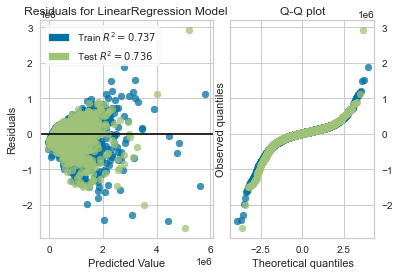

In [38]:
lr = LinearRegression()
visualizer = ResidualsPlot(lr, hist=False, qqplot=True)

visualizer.fit(poly_train, y_train)
visualizer.score(poly_test, y_test)
visualizer.show();

Heteroscedasticity continues to be an issue.

### 6th Iteration: Polynomial Regression (All Variables)

In [39]:
X = house_df.drop(['price'], axis=1)
y = house_df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.75, random_state=99)

In [40]:
pf = PolynomialFeatures(degree=2)
pf.fit(X_train)
# get_feature_names is deprecated. current: get_feature_names_out
poly_train = pd.DataFrame(pf.transform(X_train), columns=pf.get_feature_names(X_train.columns))
poly_test = pd.DataFrame(pf.transform(X_test), columns=pf.get_feature_names(X_test.columns))
poly_train

,1,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_living15^2,sqft_living15 sqft_lot15,sqft_living15 house_age,sqft_living15 renovated,sqft_lot15^2,sqft_lot15 house_age,sqft_lot15 renovated,house_age^2,house_age renovated,renovated^2
0,1.0,4.0,2.50,1914.0,3272.0,2.0,0.0,1.0,3.0,8.0,...,2937796.0,5570500.0,8570.0,0.0,10562500.0,16250.0,0.0,25.0,0.0,0.0
1,1.0,2.0,1.00,1160.0,17700.0,1.0,0.0,1.0,3.0,7.0,...,2073600.0,12960000.0,97920.0,0.0,81000000.0,612000.0,0.0,4624.0,0.0,0.0
2,1.0,3.0,1.00,1320.0,8625.0,1.0,0.0,1.0,4.0,7.0,...,1876900.0,11364150.0,78090.0,0.0,68807025.0,472815.0,0.0,3249.0,0.0,0.0
3,1.0,3.0,1.50,1740.0,4200.0,1.5,0.0,1.0,4.0,7.0,...,2755600.0,6225000.0,156040.0,0.0,14062500.0,352500.0,0.0,8836.0,0.0,0.0
4,1.0,3.0,2.50,2540.0,5612.0,2.0,0.0,1.0,3.0,9.0,...,5664400.0,15001140.0,35700.0,0.0,39727809.0,94545.0,0.0,225.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16192,1.0,2.0,1.50,1210.0,1278.0,2.0,0.0,1.0,3.0,8.0,...,1464100.0,1352780.0,8470.0,0.0,1249924.0,7826.0,0.0,49.0,0.0,0.0
16193,1.0,4.0,2.25,4370.0,22863.0,2.5,0.0,4.0,4.0,10.0,...,8880400.0,68131740.0,318860.0,2980.0,522716769.0,2446341.0,22863.0,11449.0,107.0,1.0
16194,1.0,5.0,3.25,3710.0,34200.0,2.0,0.0,1.0,3.0,8.0,...,2958400.0,39732000.0,48160.0,0.0,533610000.0,646800.0,0.0,784.0,0.0,0.0
16195,1.0,3.0,2.50,1870.0,9825.0,1.0,0.0,1.0,4.0,7.0,...,1904400.0,15835500.0,27600.0,0.0,131675625.0,229500.0,0.0,400.0,0.0,0.0


There are now 171 features.

In [41]:
eval_model(X, y, poly_train, poly_test, y_train, y_test, model_results, '5th Iteration', 'polynomial, all variables')[0]

,Model,Details,RMSE,R2 (train),Adjusted R2 (train),Cross Validation,R2 (test),Adjusted R2 (test)
0,Preliminary Model,1 feature,269556.491840,0.489914,0.489890,0.487984,0.500022,0.499999
1,1st Iteration,remove collinear and non-corr vars,223474.921916,0.657451,0.657324,0.655113,0.656356,0.656229
2,2nd Iteration,all features,208606.305222,0.699789,0.699552,0.697401,0.700563,0.700327
3,3rd Iteration,normalization/standardization,223741.772341,0.662832,0.662566,0.661560,0.655535,0.655263
4,3rd Iteration,OHE variables,199108.458588,0.742964,0.742761,0.723259,0.727209,0.726994
5,4th Iteration,"polynomial, few variables",195931.094785,0.736903,0.736806,0.724427,0.735846,0.735748
6,5th Iteration,"polynomial, all variables",159509.871110,0.827018,0.826882,0.806990,0.824924,0.824786


Polynomial regression has further improved upon the best model so far. The new model has an R-squared score of around 82%. The cross validation score is 80%, which indicates the R-squared score might be overly optimistic, but even the cross validation score is well above the previous best model. Additionally, the test R-squared score is 82%, so the model does not appear to be over-fit.

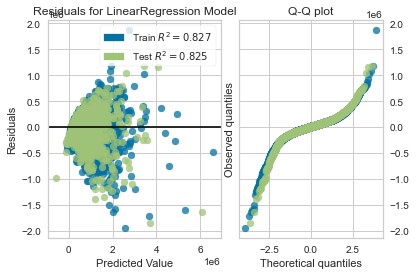

In [42]:
lr = LinearRegression()
visualizer = ResidualsPlot(lr, hist=False, qqplot=True)

visualizer.fit(poly_train, y_train)
visualizer.score(poly_test, y_test)
visualizer.show();

Interestingly, the residuals indicate that this model is far less heteroscedastic than the previous ones. It is still not homoscedastic, but the results suggest that the relationship between the variables is likely non-linear.

I also attempted to improve upon the polynomial regression models by including OHE variables and increasing the degree to 3, but these models suffered from the following issue: too many variables led to an over-fit and unusable model.

In addition, I also tried a number of other tests including:

- removing outliers
- normalizing/transforming the dependent variable
- performing lasso and ridge regression
- performing RFE (recursive feature elimination) to reduce the number of independent variables

However, none of these outperformed the current best model.

### Model Validation

Now that I have a 'best' model, I will examine it in more detail. To review, the assumptions of linear regression are:

- Linearity
- Normality
- No multicollinearity
- Homoscedasticity

The relationship between the features and price have already been shown to not be perfectly linear, as shown by the metrics from the multiple regression models.

I have also already shown that several of the features are not normally distributed. Many, including the dependent variable, are skewed due to outliers. However, even after normalizing and/or scaling the features, the models did not show significant improvement, and in some cases actually performed worse.

There are several features that are highly collinear. This makes it difficult to interpret the relative value of each individual independent variable when determining price. The ultimate goal of the stakeholder, however, is accuracy of the model. Therefore, using a model with better metrics but less interpretability is ideal. 

Multicollinearity also contributes to negating the final assumption: homoscedasticity. If there is strong multicollinearity, the model will likely suffer from heteroscedasticity. This means that the variance of the residuals will not be evenly and randomly distributed. While the final model does show some heteroscedasticity, it is actually better than all of the other models, even models that attempted to account for collinearity.

Given all of this, I will validate my current best model to determine if it will truly be effective in predicting house prices. Below I have re-created the current best model:

In [43]:
X = house_df.drop(['price'], axis=1)
y = house_df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.75, random_state=99)

In [44]:
pf = PolynomialFeatures(degree=2)
pf.fit(X_train)
# get_feature_names is deprecated. current: get_feature_names_out
poly_train = pd.DataFrame(pf.transform(X_train), columns=pf.get_feature_names(X_train.columns), index=X_train.index)
poly_test = pd.DataFrame(pf.transform(X_test), columns=pf.get_feature_names(X_test.columns), index=X_test.index)
poly_train

,1,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_living15^2,sqft_living15 sqft_lot15,sqft_living15 house_age,sqft_living15 renovated,sqft_lot15^2,sqft_lot15 house_age,sqft_lot15 renovated,house_age^2,house_age renovated,renovated^2
21270,1.0,4.0,2.50,1914.0,3272.0,2.0,0.0,1.0,3.0,8.0,...,2937796.0,5570500.0,8570.0,0.0,10562500.0,16250.0,0.0,25.0,0.0,0.0
9198,1.0,2.0,1.00,1160.0,17700.0,1.0,0.0,1.0,3.0,7.0,...,2073600.0,12960000.0,97920.0,0.0,81000000.0,612000.0,0.0,4624.0,0.0,0.0
18939,1.0,3.0,1.00,1320.0,8625.0,1.0,0.0,1.0,4.0,7.0,...,1876900.0,11364150.0,78090.0,0.0,68807025.0,472815.0,0.0,3249.0,0.0,0.0
3188,1.0,3.0,1.50,1740.0,4200.0,1.5,0.0,1.0,4.0,7.0,...,2755600.0,6225000.0,156040.0,0.0,14062500.0,352500.0,0.0,8836.0,0.0,0.0
7399,1.0,3.0,2.50,2540.0,5612.0,2.0,0.0,1.0,3.0,9.0,...,5664400.0,15001140.0,35700.0,0.0,39727809.0,94545.0,0.0,225.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21572,1.0,2.0,1.50,1210.0,1278.0,2.0,0.0,1.0,3.0,8.0,...,1464100.0,1352780.0,8470.0,0.0,1249924.0,7826.0,0.0,49.0,0.0,0.0
1768,1.0,4.0,2.25,4370.0,22863.0,2.5,0.0,4.0,4.0,10.0,...,8880400.0,68131740.0,318860.0,2980.0,522716769.0,2446341.0,22863.0,11449.0,107.0,1.0
9929,1.0,5.0,3.25,3710.0,34200.0,2.0,0.0,1.0,3.0,8.0,...,2958400.0,39732000.0,48160.0,0.0,533610000.0,646800.0,0.0,784.0,0.0,0.0
3240,1.0,3.0,2.50,1870.0,9825.0,1.0,0.0,1.0,4.0,7.0,...,1904400.0,15835500.0,27600.0,0.0,131675625.0,229500.0,0.0,400.0,0.0,0.0


In [45]:
model = eval_model(X, y, poly_train, poly_test, y_train, y_test, model_results, '5th Iteration', 'polynomial, all variables')
model_results.loc[6]

Model                              5th Iteration
Details                polynomial, all variables
RMSE                                      159510
R2 (train)                              0.827018
Adjusted R2 (train)                     0.826882
Cross Validation                         0.80699
R2 (test)                               0.824924
Adjusted R2 (test)                      0.824786
Name: 6, dtype: object

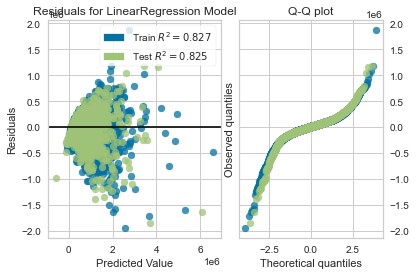

In [46]:
lr = LinearRegression()
visualizer = ResidualsPlot(lr, hist=False, qqplot=True)

visualizer.fit(poly_train, y_train)
visualizer.score(poly_test, y_test)
visualizer.show();

I will use `statsmodels` to get a more detailed analysis of the model.

In [47]:
reg_model = sm.OLS(y_train, poly_train).fit()
reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     486.3
Date:                Wed, 09 Nov 2022   Prob (F-statistic):               0.00
Time:                        01:00:09   Log-Likelihood:            -2.1614e+05
No. Observations:               16197   AIC:                         4.326e+05
Df Residuals:                   16039   BIC:                         4.338e+05
Df Model:                         157                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
1                          9.283e+04   1.73e+04      5.351      0.000    5.88e+04    1.27e+05
bedrooms                   9.729e+06   3.61e+06      2.694      0.007    2.65e+06    1.68e+07
bathrooms                 -1.058e+07   6.04e+06     -1.750      0.080   -2.24e+07    1.27e+06
sqft_living               -2.451e+04   8038.369     -3.049      0.002   -4.03e+04   -8750.247
sqft_lot                    124.2577    226.709      0.548      0.584    -320.117     568.632
floors                     -4.51e+07   7.52e+06     -6.000      0.000   -5.98e+07   -3.04e+07
waterfront                 4.107e+05   2.74e+06      0.150      0.881   -4.96e+06    5.78e+06
view                       2.531e+06   3.61e+06      0.702      0.483   -4.54e+06     9.6e+06
condition                  -1.58e+06   4.19e+06     -0.378      0.706   -9.78e+06    6.62e+06
grade                     -1.673e+07   4.23e+06     -3.954      0.000    -2.5e+07   -8.44e+06
sqft_above                 6.041e+04   8137.405      7.424      0.000    4.45e+04    7.64e+04
zipcode                   -6.351e+04   2.83e+04     -2.241      0.025   -1.19e+05   -7966.699
lat                        1.146e+08    2.3e+07      4.975      0.000    6.94e+07     1.6e+08
long                      -7.778e+06   2.44e+07     -0.318      0.750   -5.57e+07    4.01e+07
sqft_living15             -1.462e+04   6891.728     -2.122      0.034   -2.81e+04   -1116.021
sqft_lot15                  162.9942    299.253      0.545      0.586    -423.574     749.563
house_age                 -2.296e+05    1.6e+05     -1.439      0.150   -5.42e+05    8.31e+04
renovated                   4.31e+07   7.17e+06      6.009      0.000     2.9e+07    5.72e+07
bedrooms^2                  771.2593    249.336      3.093      0.002     282.532    1259.986
bedrooms bathrooms         1550.7818   3472.214      0.447      0.655   -5255.146    8356.709
bedrooms sqft_living        -20.0168      4.677     -4.280      0.000     -29.185     -10.849
bedrooms sqft_lot             0.0506      0.074      0.680      0.496      -0.095       0.197
bedrooms floors            1.842e+04   4826.390      3.817      0.000    8963.160    2.79e+04
bedrooms waterfront       -4.198e+04   2.06e+04     -2.034      0.042   -8.24e+04   -1523.761
bedrooms view              2457.2966   2412.321      1.019      0.308   -2271.123    7185.716
bedrooms condition        -2469.9649   2865.700     -0.862      0.389   -8087.057    3147.127
bedrooms grade             1826.1235   2570.556      0.710      0.477   -3212.455    6864.702
bedrooms sqft_above           1.9544      5.164      0.378      0.705      -8.169      12.077
bedrooms zipcode             -7.4615     42.182     -0.177      0.860     -90.143      75.220
bedrooms lat              -2.803e+04   1.46e+04     -1.914      0.056   -5.

A few key takeaways from the OLS regression results:

- several variables have a high p-score, which would indicate that they are not contributing to the model. However, given the number of variables, and the amount of multicollinearity, it is likely that some of the p-scores are erroneously high.

- The Omnibus score confirms that the normality assumption is not met.

- The skew is much less than I expected.

- Surprisingly, the Durbin-Watson score suggests that the data is in fact reasonably homoscedastic.

- The condition number confirms that there is high multicollinearity.

## Regression Results

***


In [48]:
model_results.loc[6]

Model                              5th Iteration
Details                polynomial, all variables
RMSE                                      159510
R2 (train)                              0.827018
Adjusted R2 (train)                     0.826882
Cross Validation                         0.80699
R2 (test)                               0.824924
Adjusted R2 (test)                      0.824786
Name: 6, dtype: object

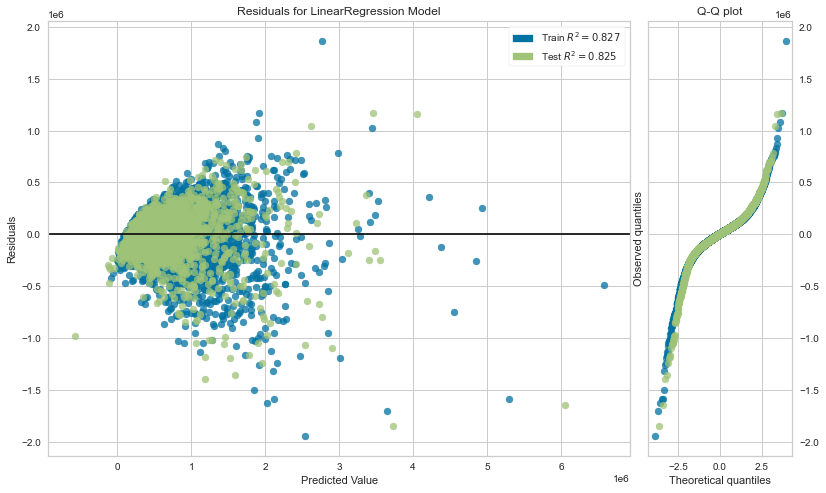

In [49]:
lr = LinearRegression()
visualizer = ResidualsPlot(lr, hist=False, qqplot=True, size=(960,576)) # size in pixels

visualizer.fit(poly_train, y_train)
visualizer.score(poly_test, y_test)
visualizer.show(outpath="graphs/residuals_qq.png");

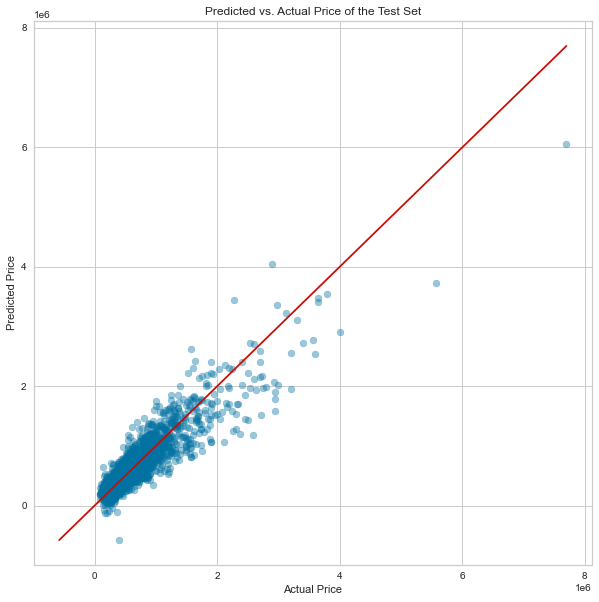

In [50]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(y_test, model[1], alpha=.4) # actual data

p1 = max(max(model[1]), max(y_test))
p2 = min(min(model[1]), min(y_test))

ax.plot([p1, p2], [p1, p2], color='r') # regression line

ax.set_xlabel('Actual Price')
ax.set_ylabel('Predicted Price')
ax.set_title('Predicted vs. Actual Price of the Test Set')
plt.savefig('graphs/predicted_vs_actual_price.png', bbox_inches='tight')
plt.show();

When determining which model to use, it is important to keep in mind the needs of the stakeholders. In this instance, the stakeholder (KC Real Estate) wants a model that can accurately and reliably predict the price of their clients homes. Ultimately, the multiple regression model (5th iteration) is by far the most accurate, and will therefore be the model presented to the stakeholders.

If the principal concern was interpretability of the model (for example, if the goal was to be able to explain to clients how to increase the value of their homes most efficiently and effectively), then this would not be the right model to choose. I would need to focus on a model that prioritizes removing multicollinearity and scales the features in order to more easier interpret and compare the variable coefficients.

The final model is multicollinear, but the metrics demonstrate that the model is not overfit and can reliably predict the house prices on unseen test data. The consistent R-squared scores across the train, cross-validation, and test sets are an indication of this.

### Recommendations

Since the model can only explain 80-82% of the variance of the house price (R-squared), there is still some room for error. The RMSE is 159,510, which means that the standard deviation of the unexplained variance (error) is, on average $159,510. This is fairly large, so the model should not be used without human oversight. The predictions will need to be checked to ensure they make sense given what is known about the home. In particular, because the residuals increase as the actual home price increases, attention should be paid to predictions above a certain threshold.

### Next Steps

There are several steps that can be taken to try and further improve the model, such as gathering additional data on the homes. It is possible that key features are missing that would increase the accuracy of the model. Alternatively, since the normality and linearity assumptions both failed, it is possible that a method other than regression could provide better insights. It might be worthwhile to consider other types of models that could outperform the current one.